# Min et al Life Facet Replication

In [1]:
%matplotlib inline

import inspect
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.svm import SVC

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *


In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

## Min et al data

- 40 participants, 817 contacts
- 16,940 calls, 63,893 SMS

![Resampled evaluation data](zimmerman_figs/resample_data.png)

## Our data

- 199 participants, 4,785 contacts
- 38,749 calls, 279,089 SMS

In [3]:
with open("../data/all_contacts_final.df", "rb") as comm_f:
    comm_df = pickle.load(comm_f)

In [4]:
replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 2,
        "family_live_together": 2,
        "sig_other": 2
    }
}


# with open("../data/zimmerman_contacts.df", "rb") as z_file:
#     zimmerman_df = pickle.load(z_file)

zimmerman_contact_types = ['work', 'social', 'family']
rev_replace_dict = {
    'contact_type': {idx:v for idx, v in enumerate(zimmerman_contact_types)}
}
zimmerman_df = comm_df.loc[(comm_df['contact_type'] != 'other') & (comm_df['contact_type'] != 'task')]
zimmerman_df = zimmerman_df.replace(replace_dict)
zimmerman_df = zimmerman_df.replace(rev_replace_dict)

In [5]:
# with open("../data/zimmerman_contacts.df", "wb") as z_file:
#     pickle.dump(zimmerman_df, z_file, -1)

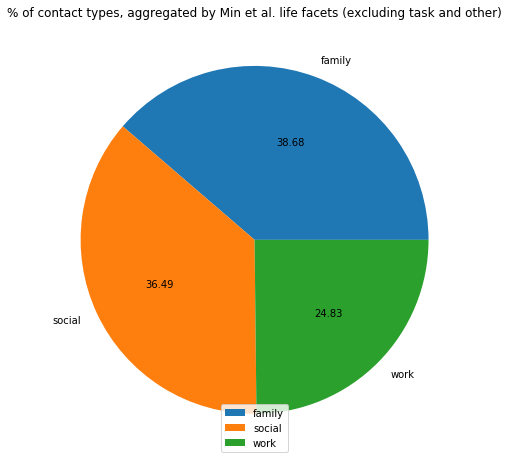

In [6]:
all_types = zimmerman_df.drop_duplicates('combined_hash').groupby('contact_type').count()
all_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types, aggregated by Min et al. life facets (excluding task and other)')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

In [7]:
display(all_types.loc[:, 'comm_direction'])

contact_type
family    1851
social    1746
work      1188
Name: comm_direction, dtype: int64

## Experiment parameters

- random resampling to balance data
- 10 fold CV, average accuracy
- one vs one polynomial SVM

## Results

![](zimmerman_figs/results.png)

In [8]:
# load models and data
features = ['baseline', 'all']

svc_models = []
svc_preds = []

# baseline
for feat in features:
    with open("../model/zimmerman_results/zimmerman_{}_svc.automl".format(feat), 'rb') as model_file:
            svc_models.append(pickle.load(model_file))
    with open("../model/zimmerman_results/zimmerman_{}_svc.predict".format(feat), 'rb') as pred_file:
        svc_preds.append(pickle.load(pred_file))

automl_models = []
automl_preds = []

# autoML
for feat in features:
    with open("../model/zimmerman_results/zimmerman_{}.automl".format(feat), 'rb') as model_file:
            automl_models.append(pickle.load(model_file))
    with open("../model/zimmerman_results/zimmerman_{}.predict".format(feat), 'rb') as pred_file:
        automl_preds.append(pickle.load(pred_file))

/home/tliu526/miniconda3/envs/auto-sklearn/lib/python3.7/site-packages/pyparsing.py:2725: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


In [9]:
contact_dict =  {
            "work": 0,
            "social": 1,
            "family": 2
        }


replace_dict = {'contact_type': contact_dict}

# load data
train = pickle.load(open('../data/zimmerman_features/zimmerman_baseline_train_features.df', 'rb'))
test =  pickle.load(open('../data/zimmerman_features/zimmerman_baseline_test_features.df', 'rb'))

train_data = train.replace(replace_dict)
test_data = test.replace(replace_dict)

train_y = train_data['contact_type']
train_X = train_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)
test_y = test_data['contact_type']
test_X = test_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)

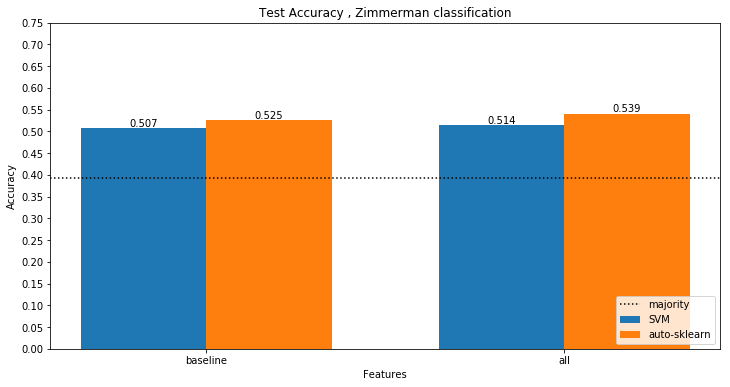

In [10]:
svc_acc = [sk_metrics.accuracy_score(test_y, pred) for pred in svc_preds]
automl_acc = [sk_metrics.accuracy_score(test_y, pred) for pred in automl_preds]
majority_acc = sk_metrics.accuracy_score(test_y, [2] * len(test_y))

plot_results(svc_acc, automl_acc, "SVM", features, "Accuracy", "Test Accuracy , Zimmerman classification", majority_acc)

/home/tliu526/miniconda3/envs/auto-sklearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


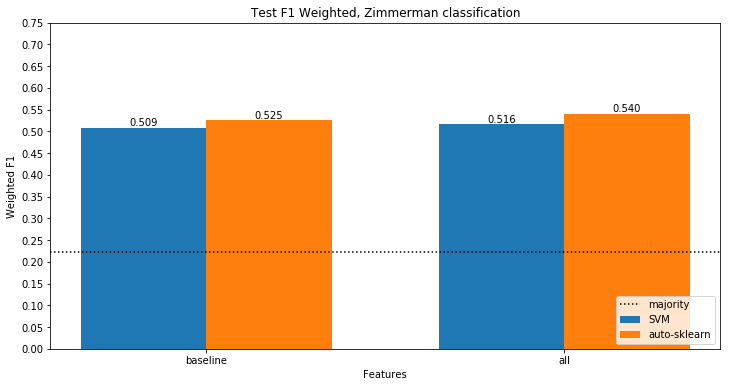

In [11]:
svc_f1 = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in svc_preds]
automl_f1 = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in automl_preds]
majority_f1 = sk_metrics.f1_score(test_y, [2] * len(test_y), average='weighted')

plot_results(svc_f1, automl_f1,  "SVM", features, "Weighted F1", "Test F1 Weighted, Zimmerman classification", majority_f1)

### Min et al. Confusion Matrix

- note: not completely comparable, different slice of the data
![](zimmerman_figs/confusion_matrix.PNG)

## Our results

### SVM confusion matrix

In [12]:
print_confusion_matrix(test_y, svc_preds[-1], zimmerman_contact_types)

,p_work,p_social,p_family
work,129,62,42
social,78,190,99
family,101,98,189


### AutoML confusion matrix

In [13]:
all_ensemble = automl_models[-1].get_models_with_weights()
print_ensemble(all_ensemble)

print_confusion_matrix(test_y, automl_preds[-1], zimmerman_contact_types)

Weight: 0.26, classifier: lda
Weight: 0.12, classifier: random_forest
Weight: 0.1, classifier: gradient_boosting
Weight: 0.1, classifier: random_forest
Weight: 0.1, classifier: gradient_boosting
Weight: 0.08, classifier: gradient_boosting
Weight: 0.06, classifier: lda
Weight: 0.06, classifier: random_forest
Weight: 0.04, classifier: sgd
Weight: 0.04, classifier: extra_trees
Weight: 0.02, classifier: extra_trees
Weight: 0.02, classifier: random_forest


,p_work,p_social,p_family
work,132,73,28
social,68,211,88
family,69,129,190
